![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer1.png)

In [ ]:
# !pip install -U torchtext==0.7

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! cp "/content/drive/My Drive/NLP/english_python_data_modified.txt" english_python_data_modified.txt
# ! cp '/content/drive/My Drive/NLP/cornell_movie_dialogs_corpus.zip' .

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
# from torchtext.data import Field, BucketIterator, TabularDataset
from torchtext.legacy.data import Field, BucketIterator, TabularDataset
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Downloading the File

In [ ]:
import requests
import os
import datetime

!wget "https://drive.google.com/u/0/uc?id=1rHb0FQ5z5ZpaY2HpyFGY6CeyDG0kTLoO&export=download"
os.rename("uc?id=1rHb0FQ5z5ZpaY2HpyFGY6CeyDG0kTLoO&export=download","english_python_data.txt")

--2021-03-09 09:41:12--  https://drive.google.com/u/0/uc?id=1rHb0FQ5z5ZpaY2HpyFGY6CeyDG0kTLoO&export=download
Resolving drive.google.com (drive.google.com)... 74.125.197.139, 74.125.197.102, 74.125.197.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.197.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-3o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/50s01ck629ob3514kt5lr1mcfvfvpg00/1615282800000/02008525212197398114/*/1rHb0FQ5z5ZpaY2HpyFGY6CeyDG0kTLoO?e=download [following]
--2021-03-09 09:41:14--  https://doc-14-3o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/50s01ck629ob3514kt5lr1mcfvfvpg00/1615282800000/02008525212197398114/*/1rHb0FQ5z5ZpaY2HpyFGY6CeyDG0kTLoO?e=download
Resolving doc-14-3o-docs.googleusercontent.com (doc-14-3o-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-14-3o-docs.googleusercontent.com (do

### Reading the File and Separating Out English Text and Python Code

In [ ]:
# https://stackoverflow.com/questions/31786823/print-lines-between-two-patterns-in-python/31787181

fastq_filename = "english_python_data_modified.txt"
fastq = open(fastq_filename) # fastq is the file object

for line in fastq:
    if line.startswith("#") or line.isalpha():
        print(line.replace("@", ">"))

Streaming output truncated to the last 5000 lines.
# Write a python program to print the smallest number in a list 

# Write a python program to remove even numbers from a list. Print the final list.

# Write a python program to print a list after removing elements from index 1 to 4

# Write a python program to remove 11 and 18 from a list. Print the final list.

# Write a python program to Remove multiple empty spaces from  List of strings. Print the original and final lists.

# Write a python function to get the Cumulative sum of a list 

# Write a python program to print the distance between first and last occurrence of even element.

# Write a python fuction to create an empty list 

# Write a python program to print a list with all elements as 5 and of length 10

# Write a python program to reverse a list and print it.  

# Write a python program to print odd numbers in a List 

# Write a python program to print negative Numbers in a List 

# Write a python program print the the n

In [ ]:
def generate_df(filename):
  with open(filename) as file_in:

    newline = '\n'
    lineno = 0
    lines = []
    Question = []
    Answer = []
    Question_Ind =-1
    mystring = "NA"
    revised_string = "NA"
    Initial_Answer = False
    # you may also want to remove whitespace characters like `\n` at the end of each line
    for line in file_in:
      lineno = lineno +1
      if line in ['\n', '\r\n']:
        pass
      else:
        linex = line.rstrip() # strip trailing spaces and newline
        # if string[0].isdigit()
        if linex.startswith('# '): ## to address question like " # write a python function to implement linear extrapolation"
          if Initial_Answer:
            Answer.append(revised_string)
            revised_string = "NA"
            mystring = "NA"
          Initial_Answer = True
          Question.append(linex.strip('# '))
          # Question_Ind = Question_Ind +1
        
        elif linex.startswith('#'): ## to address question like "#24. Python Program to Find Numbers Divisible by Another Number"
          
          linex = linex.strip('#')
          # print(linex)
          # print(f"amit:{len(linex)}:LineNo:{lineno}")
          if (linex[0].isdigit()):  ## stripping first number which is 2
            # print("Amit")
            linex = linex.strip(linex[0])
          if (linex[0].isdigit()): ## stripping 2nd number which is 4
            linex = linex.strip(linex[0])
          if (linex[0]=="."):
            linex = linex.strip(linex[0])
          if (linex[0].isspace()):
            linex = linex.strip(linex[0])  ## stripping out empty space
          if Initial_Answer:
            Answer.append(revised_string)
            revised_string = "NA"
            mystring = "NA"
          Initial_Answer = True
          Question.append(linex)

        else:
        # linex = '\n'.join(linex)
          if (mystring == "NA"):
            mystring = f"{linex}{newline}"
            revised_string = mystring
          # print(f"I am here:{mystring}")
          else:
            mystring = f"{linex}{newline}"
            if (revised_string == "NA"):
              revised_string = mystring
            # print(f"I am here revised_string:{revised_string}")
            else:
              revised_string = revised_string + mystring 
            # print(f"revised_string:{revised_string}")
      # Answer.append(string)
    lines.append(linex)
    Answer.append(revised_string)
    return Question, Answer

In [ ]:
Question, Answer =  generate_df("english_python_data_modified.txt")
print(f"Length of Question:{len(Question)}")
print(f"Length of Answer:{len(Answer)}")

Length of Question:4850
Length of Answer:4850


In [ ]:
# Answer[0]
# num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\nprint(f'Sum: {sum}')\n\n\n

In [ ]:
# with open("english_emp.txt") as file_in:
#   newline = '\n'
#   lines = []
#   Question = []
#   Answer = []
#   Question_Ind =-1
#   mystring = "NA"
#   revised_string = "NA"
#   Initial_Answer = False
#   # you may also want to remove whitespace characters like `\n` at the end of each line
#   for line in file_in:
#     linex = line.rstrip() # strip trailing spaces and newline
#     if linex.startswith('# '):
#       if Initial_Answer:
#         # print(f"Answer:{Answer}")
#         Answer.append(revised_string)
#         revised_string = "NA"
#         mystring = "NA"
#       Initial_Answer = True
#       Question.append(linex.strip('# '))
#       Question_Ind = Question_Ind +1
#     else:
#       # linex = '\n'.join(linex)
#       if (mystring == "NA"):
#         mystring = f"{linex}{newline}"
#         revised_string = mystring
#         # print(f"I am here:{mystring}")
#       else:
#         mystring = f"{linex}{newline}"
#         if (revised_string == "NA"):
#           revised_string = mystring
#           # print(f"I am here revised_string:{revised_string}")
#         else:
#           revised_string = revised_string + mystring 
#           # print(f"revised_string:{revised_string}")
#       # Answer.append(string)
#     lines.append(linex)
#   Answer.append(revised_string)
# print(Question[1])

In [ ]:
## do some random check
print(f"Question[0]:\n{Question[0]}")
print(f"Answer[0]:\n{Answer[0]}")

Question[0]:
write a python program to add two numbers
Answer[0]:
num1 = 1.5
num2 = 6.3
sum = num1 + num2
print(f'Sum: {sum}')



In [ ]:
## do some random check
print(f"Question[1]:\n{Question[1]}")
print(f"Answer[1]:\n{Answer[1]}")

Question[1]:
write a python function to add two user provided numbers and return the sum
Answer[1]:
def add_two_numbers(num1, num2):
    sum = num1 + num2
    return sum



In [ ]:
## do some random check
print(f"Question[4849]:\n{Question[4849]}")
print(f"Answer[4849]:\n{Answer[4849]}")

Question[4849]:
write a program to Binary Right Shift a number
Answer[4849]:
c = a >> 2
print("Binary Right Shift", c)



### Converting into dataframe and dumping into CSV

In [ ]:
import pandas as pd
df_Question = pd.DataFrame(Question, columns =['Question']) 
df_Answer = pd.DataFrame(Answer,columns =['Answer']) 
frames = [df_Question, df_Answer]
combined_question_answer = pd.concat(frames,axis=1)

In [ ]:
combined_question_answer.head(2)

,Question,Answer
0,write a python program to add two numbers,num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\npri...
1,write a python function to add two user provid...,"def add_two_numbers(num1, num2):\n sum = nu..."


In [ ]:
combined_question_answer.to_csv("combined_question_answer_from_df.csv",index=False)

In [ ]:
combined_question_answer['AnswerLen'] = combined_question_answer['Answer'].astype(str).map(len)

In [ ]:
combined_question_answer.size

14550

In [ ]:
combined_question_answer.head(2)

,Question,Answer,AnswerLen
0,write a python program to add two numbers,num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\npri...,61
1,write a python function to add two user provid...,"def add_two_numbers(num1, num2):\n sum = nu...",70


In [ ]:
combined_question_answer_df = combined_question_answer[combined_question_answer['AnswerLen'] < 495] 
combined_question_answer_df.size

14082

In [ ]:
combined_question_answer_df = combined_question_answer_df.drop(['AnswerLen'], axis=1)

In [ ]:
combined_question_answer_df.head(2)

,Question,Answer
0,write a python program to add two numbers,num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\npri...
1,write a python function to add two user provid...,"def add_two_numbers(num1, num2):\n sum = nu..."


In [ ]:
from sklearn.model_selection import train_test_split
train_combined_question_answer, val_combined_question_answer = train_test_split(combined_question_answer_df, test_size=0.2)
train_combined_question_answer.to_csv("train_combined_question_answer.csv",index=False)
val_combined_question_answer.to_csv("val_combined_question_answer.csv",index=False)

### Downloading spacy and tokenization

In [ ]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
spacy_en = spacy.load('en')

In [ ]:
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
TEXT = Field(tokenize = tokenize_en, 
            eos_token = '<eos>',
            init_token = '<sos>', 
            lower = True,
            batch_first = True)

fields = [("Question", TEXT), ("Answer", TEXT)]

In [ ]:
!wget https://raw.githubusercontent.com/pytorch/pytorch/master/torch/utils/collect_env.py
!python collect_env.py
!python -c "import torchtext; print(\"torchtext version is \", torchtext.__version__)"

--2021-03-09 09:58:22--  https://raw.githubusercontent.com/pytorch/pytorch/master/torch/utils/collect_env.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15203 (15K) [text/plain]
Saving to: ‘collect_env.py.1’

collect_env.py.1    100%[===================>]  14.85K  --.-KB/s    in 0s      

2021-03-09 09:58:23 (35.6 MB/s) - ‘collect_env.py.1’ saved [15203/15203]

PyTorch version: 1.8.0+cu101
Is debug build: False
CUDA used to build PyTorch: 10.1
ROCM used to build PyTorch: N/A

OS: Ubuntu 18.04.5 LTS (x86_64)
GCC version: (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Clang version: 6.0.0-1ubuntu2 (tags/RELEASE_600/final)
CMake version: version 3.12.0

Python version: 3.7 (64-bit runtime)
Is CUDA available: False
CUDA runtime version: 11.0.221
GPU models and configur

An example article-title pair looks like this:

**article**: the algerian cabinet chaired by president abdelaziz bouteflika on sunday adopted the #### finance bill predicated on an oil price of ## dollars a barrel and a growth rate of #.# percent , it was announced here .

**title**: algeria adopts #### finance bill with oil put at ## dollars a barrel

In [ ]:
train_data, valid_data = TabularDataset.splits(path=f'/content',
                                     train='train_combined_question_answer.csv', validation='val_combined_question_answer.csv',
                                     format='csv', skip_header=True, fields=fields)

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
#print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 3755
Number of validation examples: 939


In [ ]:
# a sample of the preprocessed data
print(train_data[0].Question, train_data[0].Answer)

['reverse', 'the', 'string'] ['rev_str', '=', 'reversed(my_str', ')']


In [ ]:
TEXT.build_vocab(train_data, min_freq = 2)

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")

Unique tokens in TEXT vocabulary: 5365


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
BATCH_SIZE = 32

train_iterator, valid_iterator = BucketIterator.splits(
    (train_data, valid_data), 
     batch_size = BATCH_SIZE,
     device = device,
     sort_key=lambda x: len(x.Question),
     shuffle=True, 
     sort_within_batch=False, 
     repeat=False)

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-encoder.png)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 500):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-attention.png)

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-decoder.png)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 500):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

10000
11000
11100
11100
11100

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [ ]:
INPUT_DIM = len(TEXT.vocab)
OUTPUT_DIM = len(TEXT.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [ ]:
SRC_PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
TRG_PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 8,335,349 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [ ]:
model.apply(initialize_weights);

In [ ]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        Question = batch.Question
        Answer = batch.Answer
        
        optimizer.zero_grad()
        
        output, _ = model(Question, Answer[:,:-1])
        
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        Answer = Answer[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, Answer)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            Question = batch.Question
            Answer = batch.Answer

            output, _ = model(Question, Answer[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            Answer = Answer[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, Answer)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 4m 39s
	Train Loss: 3.291 | Train PPL:  26.874
	 Val. Loss: 2.815 |  Val. PPL:  16.685
Epoch: 02 | Time: 4m 39s
	Train Loss: 2.750 | Train PPL:  15.645
	 Val. Loss: 2.497 |  Val. PPL:  12.152
Epoch: 03 | Time: 4m 37s
	Train Loss: 2.379 | Train PPL:  10.795
	 Val. Loss: 2.243 |  Val. PPL:   9.425
Epoch: 04 | Time: 4m 35s
	Train Loss: 2.088 | Train PPL:   8.065
	 Val. Loss: 2.078 |  Val. PPL:   7.992
Epoch: 05 | Time: 4m 36s
	Train Loss: 1.844 | Train PPL:   6.320
	 Val. Loss: 1.944 |  Val. PPL:   6.986
Epoch: 06 | Time: 4m 34s
	Train Loss: 1.627 | Train PPL:   5.090
	 Val. Loss: 1.809 |  Val. PPL:   6.104
Epoch: 07 | Time: 4m 31s
	Train Loss: 1.446 | Train PPL:   4.245
	 Val. Loss: 1.725 |  Val. PPL:   5.611
Epoch: 08 | Time: 4m 46s
	Train Loss: 1.285 | Train PPL:   3.613
	 Val. Loss: 1.633 |  Val. PPL:   5.122
Epoch: 09 | Time: 4m 43s
	Train Loss: 1.154 | Train PPL:   3.171
	 Val. Loss: 1.573 |  Val. PPL:   4.820
Epoch: 10 | Time: 4m 32s
	Train Loss: 1.029 | Train PPL

In [ ]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, valid_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.514 | Test PPL:   4.547 |


In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [ ]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
example_idx = 8

src = vars(train_data.examples[example_idx])['Question']
trg = vars(train_data.examples[example_idx])['Answer']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['write', 'a', 'python', 'program', 'to', 'calculate', 'the', 'square', 'root']
trg = ['num', '=', '8', '\n', 'num_sqrt', '=', 'num', '*', '*', '0.5', '\n', "print('the", 'square', 'root', 'of', '%', '0.3f', 'is', '%', "0.3f'%(num", ',', 'num_sqrt', ')', ')']


In [ ]:
translation, attention = translate_sentence(src, TEXT, TEXT, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['x', '=', '5', '\n', 'y', '=', '10', '\n', 'x', '=', 'x', '*', 'x', '*', 'x', '*', 'x', '\n', "print('the", 'side', '*', 'x', 'of', 'y', ':', '{', '}', "'", ')', '<eos>']


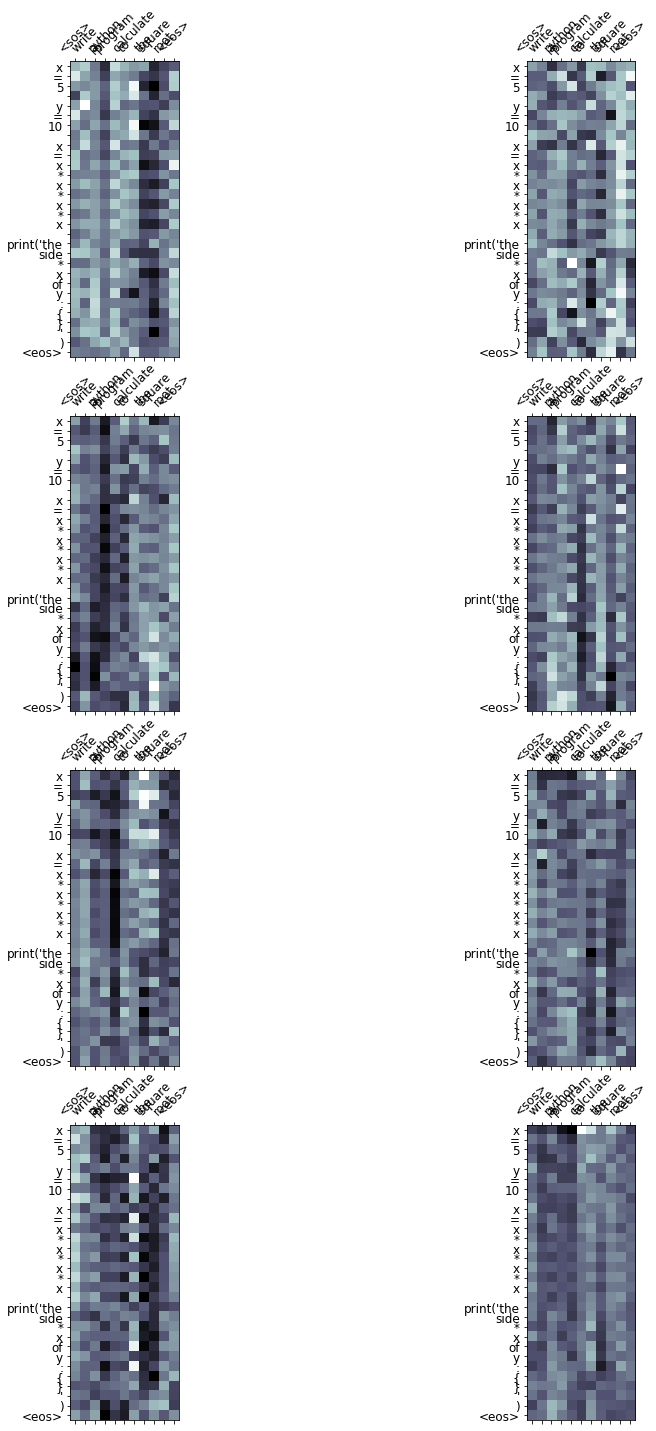

In [ ]:
display_attention(src, translation, attention)

In [ ]:
example_idx = 1

src = vars(valid_data.examples[example_idx])['Question']
trg = vars(valid_data.examples[example_idx])['Answer']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['write', 'a', 'python', 'program', 'to', 'rotate', 'a', 'list', '10', 'times', 'and', 'print', 'it']
trg = ['list', '=', '[', '11,22,33,44,55,66,77,88,99', ']', '\n', 'n', '=', '10', '\n', 'finallist', '=', '[', ']', '\n', 'for', 'i', 'in', 'range(0', ',', 'n', ')', ':', '\n    ', 'finallist.append(list[(i+d)%n', ']', ')', '\n', 'print(finallist', ')']


In [ ]:
translation, attention = translate_sentence(src, TEXT, TEXT, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['def', '<unk>', ')', ':', '\n    ', 'for', 'i', 'in', 'range(n', ')', ':', '\n        ', '<unk>', ')', '<eos>']


In [ ]:
print(translation)

['def', '<unk>', ')', ':', '\n    ', 'for', 'i', 'in', 'range(n', ')', ':', '\n        ', '<unk>', ')', '<eos>']


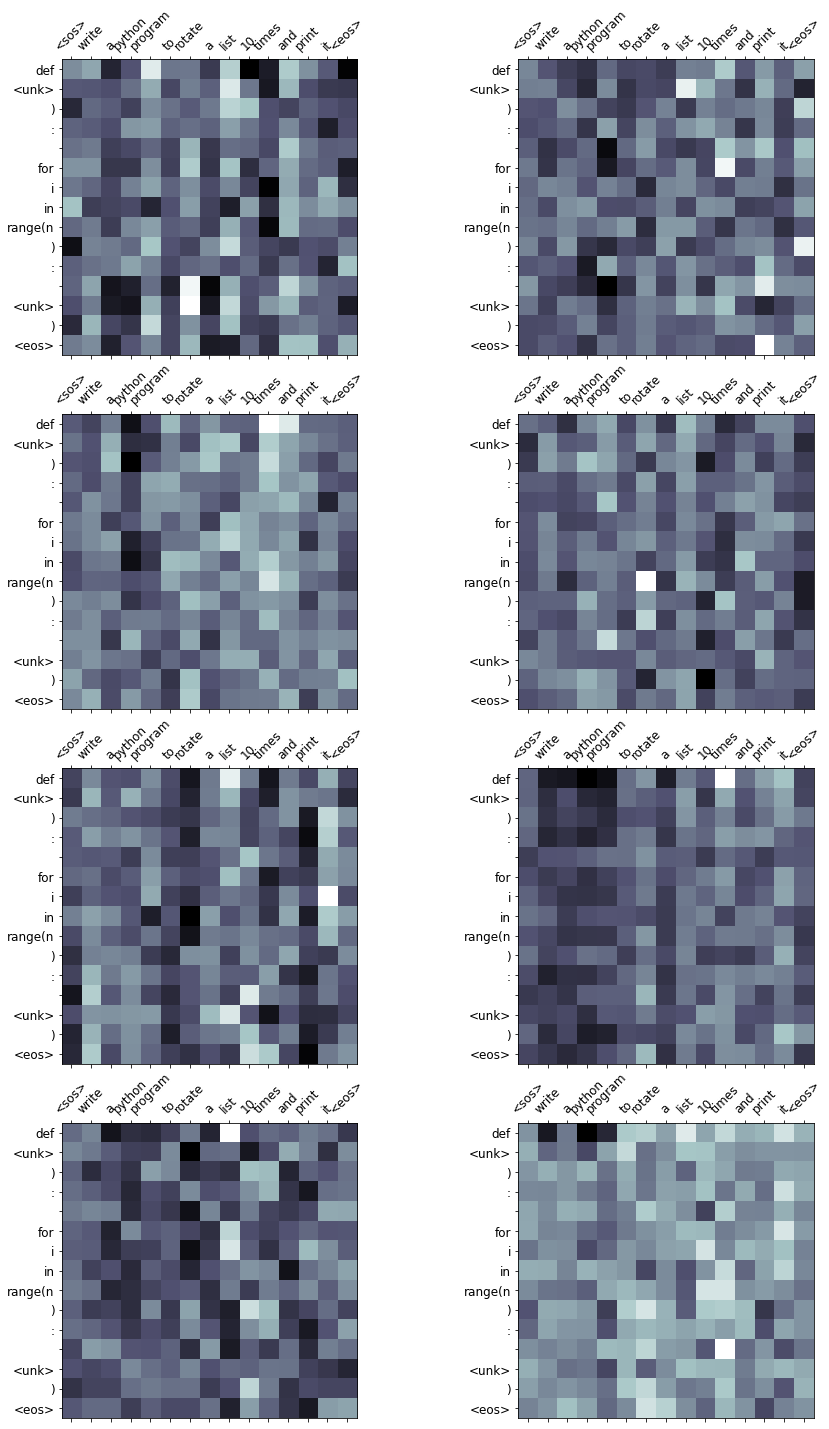

In [ ]:
display_attention(src, translation, attention)